In [192]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [193]:
df = pd.read_csv("final_df.csv")

In [194]:
df

,DATE_TIME,DATE,TIME,DC_POWER,AC_POWER,DAILY_YIELD,DAILY_YIELD_diff,TOTAL_YIELD,TOTAL_YIELD_diff,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:15:00,2020-05-15,00:15:00,0.0,0.0,0.0,0.0,1.215279e+09,0.0,26.880811,24.421869,0.0
1,2020-05-15 00:30:00,2020-05-15,00:30:00,0.0,0.0,0.0,0.0,1.215279e+09,0.0,26.682055,24.427290,0.0
2,2020-05-15 00:45:00,2020-05-15,00:45:00,0.0,0.0,0.0,0.0,1.215279e+09,0.0,26.500589,24.420678,0.0
3,2020-05-15 01:00:00,2020-05-15,01:00:00,0.0,0.0,0.0,0.0,1.215279e+09,0.0,26.596148,25.088210,0.0
4,2020-05-15 01:15:00,2020-05-15,01:15:00,0.0,0.0,0.0,0.0,1.215279e+09,0.0,26.512740,25.317970,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2835,2020-06-17 22:45:00,2020-06-17,22:45:00,0.0,0.0,4306.0,0.0,1.215486e+09,0.0,23.511703,22.856201,0.0
2836,2020-06-17 23:00:00,2020-06-17,23:00:00,0.0,0.0,4306.0,0.0,1.215486e+09,0.0,23.482282,22.744190,0.0
2837,2020-06-17 23:15:00,2020-06-17,23:15:00,0.0,0.0,4306.0,0.0,1.215486e+09,0.0,23.354743,22.492245,0.0
2838,2020-06-17 23:30:00,2020-06-17,23:30:00,0.0,0.0,4306.0,0.0,1.215486e+09,0.0,23.291048,22.373909,0.0


In [195]:
tf.keras.utils.set_random_seed(1024)

In [196]:
cleaned_df = df.drop(columns=["DATE_TIME","DATE","TIME","TOTAL_YIELD_diff", "DAILY_YIELD_diff","AC_POWER","TOTAL_YIELD"], errors="ignore")
df = cleaned_df.to_numpy().astype(np.float32)

In [197]:
cleaned_df

,DC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,0.0,0.0,26.880811,24.421869,0.0
1,0.0,0.0,26.682055,24.427290,0.0
2,0.0,0.0,26.500589,24.420678,0.0
3,0.0,0.0,26.596148,25.088210,0.0
4,0.0,0.0,26.512740,25.317970,0.0
...,...,...,...,...,...
2835,0.0,4306.0,23.511703,22.856201,0.0
2836,0.0,4306.0,23.482282,22.744190,0.0
2837,0.0,4306.0,23.354743,22.492245,0.0
2838,0.0,4306.0,23.291048,22.373909,0.0


In [198]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # Previously, I was using UpSampling. I am trying Transposed Convolution this time around.
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = df.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

Model: "auto_encoder_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 1, 32)             63264     
                                                                 
 sequential_29 (Sequential)  (None, 5)                 66597     
                                                                 
Total params: 129861 (507.27 KB)
Trainable params: 128709 (502.77 KB)
Non-trainable params: 1152 (4.50 KB)
_________________________________________________________________


In [199]:
print(cleaned_df.shape)

(2840, 5)


In [200]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(df, df, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
20/20 [==============================] - 5s 62ms/step - loss: 614.9539 - val_loss: 583.5383
Epoch 2/100
20/20 [==============================] - 1s 34ms/step - loss: 607.2346 - val_loss: 579.5481
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 597.6902 - val_loss: 574.3623
Epoch 4/100
20/20 [==============================] - 1s 35ms/step - loss: 589.8557 - val_loss: 567.9189
Epoch 5/100
20/20 [==============================] - 1s 32ms/step - loss: 579.5011 - val_loss: 533.6650
Epoch 6/100
20/20 [==============================] - 1s 26ms/step - loss: 562.6655 - val_loss: 497.8182
Epoch 7/100
20/20 [==============================] - 1s 31ms/step - loss: 542.7338 - val_loss: 469.5809
Epoch 8/100
20/20 [==============================] - 1s 35ms/step - loss: 518.4727 - val_loss: 487.0169
Epoch 9/100
20/20 [==============================] - 1s 36ms/step - loss: 493.1294 - val_loss: 522.0318
Epoch 10/100
20/20 [==============================] - 0s 17ms/st

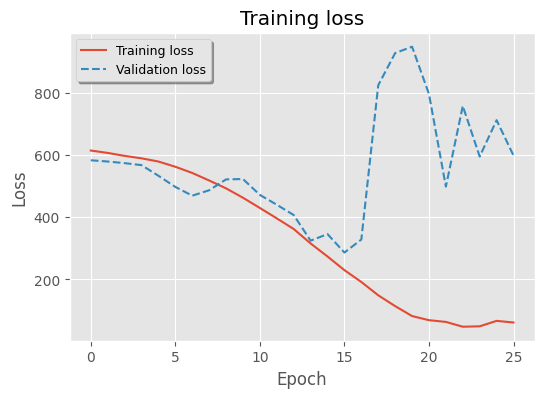

In [201]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [202]:
# train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(df, df, verbose=0)

# print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)


Testing dataset error:  303.7969055175781
